In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

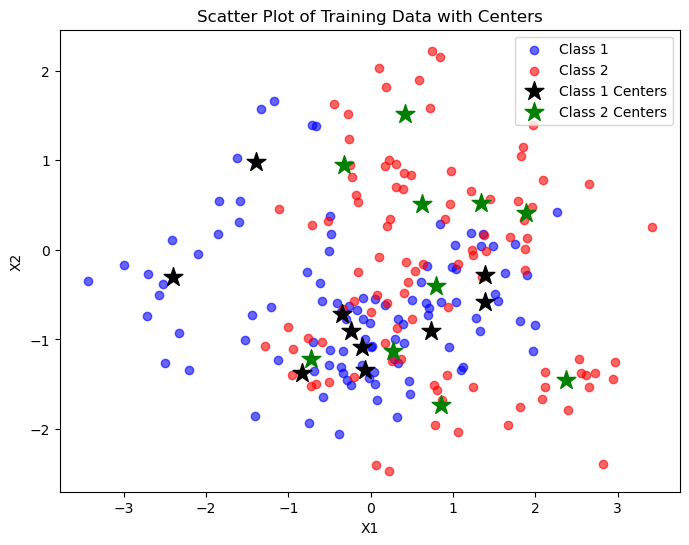

In [2]:
### Part 1: Generate Data ###
# Set seed based on the last 4 digits of your UIN (8371)
np.random.seed(8371)

# Generate 20 centers from a 2D normal distribution
num_centers = 20
means = np.random.randn(num_centers, 2)  # 2D means, shape (20, 2)
cov = np.eye(2) * (1 / 1/5)  # Covariance matrix (identity with variance 1/5)

# Split the 20 centers into two classes
class_1_centers = means[:10]
class_2_centers = means[10:]

# Function to generate samples from the centers
def generate_samples_vectorized(centers, num_samples, class_label):
    num_centers = len(centers)
    center_indices = np.random.choice(num_centers, num_samples)
    samples = np.random.multivariate_normal([0, 0], cov, size=num_samples) + centers[center_indices]
    labels = np.full(num_samples, class_label)
    return samples, labels

# Generate training data (200 samples: 100 per class)
train_samples_class_1, train_labels_class_1 = generate_samples_vectorized(class_1_centers, 100, 0)
train_samples_class_2, train_labels_class_2 = generate_samples_vectorized(class_2_centers, 100, 1)

# Generate test data (10,000 samples: 5,000 per class)
test_samples_class_1, test_labels_class_1 = generate_samples_vectorized(class_1_centers, 5000, 0)
test_samples_class_2, test_labels_class_2 = generate_samples_vectorized(class_2_centers, 5000, 1)

# Combine training and test data
train_samples = np.vstack([train_samples_class_1, train_samples_class_2])
train_labels = np.hstack([train_labels_class_1, train_labels_class_2])
test_samples = np.vstack([test_samples_class_1, test_samples_class_2])
test_labels = np.hstack([test_labels_class_1, test_labels_class_2])

# Scatter plot of training data
plt.figure(figsize=(8, 6))
plt.scatter(train_samples_class_1[:, 0], train_samples_class_1[:, 1], color='blue', label='Class 1', alpha=0.6)
plt.scatter(train_samples_class_2[:, 0], train_samples_class_2[:, 1], color='red', label='Class 2', alpha=0.6)
plt.scatter(class_1_centers[:, 0], class_1_centers[:, 1], color='black', marker='*', s=200, label='Class 1 Centers')
plt.scatter(class_2_centers[:, 0], class_2_centers[:, 1], color='green', marker='*', s=200, label='Class 2 Centers')
plt.title("Scatter Plot of Training Data with Centers")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.show()

In [3]:
### Part 2: kNN Implementation ###

def euclidean_distance(train_data, test_data):
    # Compute the Euclidean distance between all training and test points
    return np.sqrt(np.sum((train_data[:, np.newaxis, :] - test_data[np.newaxis, :, :]) ** 2, axis=2))

def k_nearest_neighbors(train_samples, train_labels, test_samples, k):
    # Calculate distances
    dists = euclidean_distance(train_samples, test_samples)
    
    # Get the k nearest neighbors
    nearest_neighbors_indices = np.argsort(dists, axis=0)[:k, :]
    nearest_neighbors_labels = train_labels[nearest_neighbors_indices]
    
    # Use mode to find the most common label
    predictions, _ = mode(nearest_neighbors_labels, axis=0)
    
    return predictions.flatten()

# Test the kNN function with k = 1, 3, 5
for k in [1, 3, 5]:
    predictions = k_nearest_neighbors(train_samples, train_labels, test_samples, k)
    cm = confusion_matrix(test_labels, predictions)
    print(f"Confusion Matrix for k={k}:\n", cm)


Confusion Matrix for k=1:
 [[3666 1334]
 [1745 3255]]
Confusion Matrix for k=3:
 [[3890 1110]
 [1726 3274]]
Confusion Matrix for k=5:
 [[3902 1098]
 [1635 3365]]


In [4]:
### Part 3: kNN with Cross-Validation Using Built-in `KNeighborsClassifier` ###
# Set the candidate K values from 1 to 180
k_values = np.arange(1, 181)

def cross_validate_knn(train_samples, train_labels, k_values):
    cv_errors = []

    for k in k_values:
        # Instantiate the kNN classifier with the current value of K
        knn = KNeighborsClassifier(n_neighbors=k)

        # Perform 10-fold cross-validation and compute the accuracy for each fold
        scores = cross_val_score(knn, train_samples, train_labels, cv=10, scoring='accuracy')

        # Compute the mean error for this K (1 - accuracy)
        mean_error = 1 - np.mean(scores)
        cv_errors.append(mean_error)
    
    return cv_errors

# Perform cross-validation to find the best K
cv_errors = cross_validate_knn(train_samples, train_labels, k_values)

# Find the minimum error and select the largest K with the smallest error
min_error = np.min(cv_errors)
best_ks = [k for k, error in zip(k_values, cv_errors) if error == min_error]
best_k = max(best_ks)

print(f"Best K from Cross-Validation: {best_k}")

# Report the confusion matrix and test error
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(train_samples, train_labels)
best_k_predictions = best_knn.predict(test_samples)
conf_matrix = confusion_matrix(test_labels, best_k_predictions)
test_error = np.mean(best_k_predictions != test_labels)

print(f"Confusion Matrix for best K={best_k}:\n{conf_matrix}")
print(f"Test Error for best K={best_k}: {test_error}")


Best K from Cross-Validation: 12
Confusion Matrix for best K=12:
[[4377  623]
 [1859 3141]]
Test Error for best K=12: 0.2482


In [5]:
# Normalize data using StandardScaler
scaler = StandardScaler()
train_samples = scaler.fit_transform(train_samples)
test_samples = scaler.transform(test_samples)
class_1_centers = scaler.transform(class_1_centers)
class_2_centers = scaler.transform(class_2_centers)

### Part 4: Adjusted Bayes Rule Implementation ###

s2 = 1 / 5  # Variance parameter
exponent_factor = -1 / (2 * s2)

# Adjusted Bayes rule using log-likelihoods to avoid numerical underflow
def bayes_rule_log(test_samples, class_1_centers, class_2_centers):
    # Compute log-likelihoods for P(X=x|Y=1)
    log_p_y1_given_x = np.log(np.sum(np.exp(exponent_factor * np.sum((test_samples[:, np.newaxis, :] - class_1_centers) ** 2, axis=2)), axis=1))

    # Compute log-likelihoods for P(X=x|Y=0)
    log_p_y0_given_x = np.log(np.sum(np.exp(exponent_factor * np.sum((test_samples[:, np.newaxis, :] - class_2_centers) ** 2, axis=2)), axis=1))
    
    # Predict Y=1 if log P(Y=1|X=x) >= log P(Y=0|X=x)
    predictions = (log_p_y1_given_x >= log_p_y0_given_x).astype(int)
    
    return predictions

# Test the adjusted Bayes rule
bayes_predictions_log = bayes_rule_log(test_samples, class_1_centers, class_2_centers)

# Confusion matrix for the adjusted Bayes rule
bayes_cm_log = confusion_matrix(test_labels, bayes_predictions_log)
print("Confusion Matrix for Adjusted Bayes Rule (log-likelihood):\n", bayes_cm_log)

# Calculate the test error
test_error_bayes_log = np.mean(bayes_predictions_log != test_labels)
print(f"Test Error for Adjusted Bayes Rule: {test_error_bayes_log}")


Confusion Matrix for Adjusted Bayes Rule (log-likelihood):
 [[ 586 4414]
 [3321 1679]]
Test Error for Adjusted Bayes Rule: 0.7735


In [ ]:
### Part 5: Simulation Study ###
# First, define all the functions that you'll use later, including simulation_study_adjusted

def simulation_study_adjusted(num_simulations=50):
    test_errors_knn7 = []
    test_errors_cvknn = []
    test_errors_bayes = []
    best_ks = []
    s2_best = 1/3  # Best variance determined from part 4

    for _ in range(num_simulations):
        # Generate new data
        train_samples_class_1, train_labels_class_1 = generate_samples_vectorized(class_1_centers, 100, 0)
        train_samples_class_2, train_labels_class_2 = generate_samples_vectorized(class_2_centers, 100, 1)
        train_samples = np.vstack([train_samples_class_1, train_samples_class_2])
        train_labels = np.hstack([train_labels_class_1, train_labels_class_2])

        test_samples_class_1, test_labels_class_1 = generate_samples_vectorized(class_1_centers, 5000, 0)
        test_samples_class_2, test_labels_class_2 = generate_samples_vectorized(class_2_centers, 5000, 1)
        test_samples = np.vstack([test_samples_class_1, test_samples_class_2])
        test_labels = np.hstack([test_labels_class_1, test_labels_class_2])

        # kNN with k = 7
        predictions_knn7 = k_nearest_neighbors(train_samples, train_labels, test_samples, 7)
        test_errors_knn7.append(np.mean(predictions_knn7 != test_labels))

        # kNN with cross-validation (find best k)
        cv_errors = cross_validate_knn(train_samples, train_labels, k_values)
        best_k = k_values[np.argmin(cv_errors)]
        best_ks.append(best_k)
        predictions_cvknn = k_nearest_neighbors(train_samples, train_labels, test_samples, best_k)
        test_errors_cvknn.append(np.mean(predictions_cvknn != test_labels))

        # Bayes rule with best s2
        exponent_factor = -1 / (2 * s2_best)
        bayes_predictions = bayes_rule_log(test_samples, class_1_centers, class_2_centers)
        test_errors_bayes.append(np.mean(bayes_predictions != test_labels))

    # Boxplots of the test errors
    plt.boxplot([test_errors_knn7, test_errors_cvknn, test_errors_bayes], labels=["kNN K=7", "kNN CV", "Bayes"])
    plt.ylabel("Test Error")
    plt.title("Test Errors for kNN K=7, kNN with CV, and Bayes Rule")
    plt.show()

    # Report the summary statistics for selected ks
    print(f"Five-number summary for selected K values: Min: {np.min(best_ks)}, Max: {np.max(best_ks)}, Median: {np.median(best_ks)}, 25th Percentile: {np.percentile(best_ks, 25)}, 75th Percentile: {np.percentile(best_ks, 75)}")

# Then call the function
simulation_study_adjusted()
